In [2]:
# Antiviral Potency Prediction with Transfer Learning


# -------------------------------------------------
# 1. Setup and Imports
# -------------------------------------------------
import sys
import os
import numpy as np
import pandas as pd
import torch
import gpytorch
import datamol as dm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
import seaborn as sns
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, AllChem
from tqdm import tqdm


# Navigate to project root
root_dir = os.path.abspath(os.path.join(os.getcwd(), "DD"))
sys.path.append(root_dir)

# Import project utilities
from utils import *
import polaris as po
from abc import ABC, abstractmethod


# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [4]:

# -------------------------------------------------
# 2. Load and Preprocess Data
# -------------------------------------------------

# 2.1 Load competition data
print("Loading competition data...")
CHALLENGE = "antiviral-potency-2025"
competition = po.load_competition(f"asap-discovery/{CHALLENGE}")
competition.cache()

# Get train-test split
train, test = competition.get_train_test_split()

# 2.2 Process competition data
print("Processing competition data...")
# Extract data into lists
smiles = []
pIC50_MERS = []
pIC50_SARS = []

# Iterate through dataset
for i in range(len(train)):
    item = train[i]
    # Extract SMILES string
    smiles.append(item[0])
    # Extract pIC50 values
    pIC50_MERS.append(item[1]['pIC50 (MERS-CoV Mpro)'])
    pIC50_SARS.append(item[1]['pIC50 (SARS-CoV-2 Mpro)'])

# Create and clean DataFrame
mpro_df_comp = pd.DataFrame({
    'SMILES': smiles,
    'pIC50_MERS': pIC50_MERS,
    'pIC50_SARS': pIC50_SARS
})
mpro_df_comp = mpro_df_comp.dropna()  # Remove rows with missing values

# 2.3 Load and process MPRO dataset (2k data points)
print("Loading MPRO dataset...")
mpro_dataset = pd.read_csv('DD/data/Mpro_sorted.csv')
# Select relevant columns and clean data
mpro_dataset = mpro_dataset[['SMILES', 'affinity']]
mpro_dataset.dropna(inplace=True)

# Convert SMILES to molecular fingerprints
print("Converting SMILES to fingerprints...")

# MPRO dataset fingerprints
X_mpro = []
Y_mpro = []
for i, row in mpro_dataset.iterrows():
    try:
        mol = dm.to_mol(row['SMILES'])
        if mol is not None:
            X_mpro.append(dm.to_fp(mol))
            Y_mpro.append(row['affinity'])
    except Exception as e:
        print(f"Error processing molecule {i}: {e}")

X_mpro = np.array(X_mpro)
Y_mpro = np.array(Y_mpro)

# Competition dataset fingerprints
X_train_comp = []
for smi in mpro_df_comp['SMILES']:
    try:
        mol = dm.to_mol(smi)
        if mol is not None:
            X_train_comp.append(dm.to_fp(mol))
    except Exception as e:
        print(f"Error processing molecule: {e}")

X_train_comp = np.array(X_train_comp)
Y_sars = mpro_df_comp['pIC50_SARS'].to_numpy()
Y_mers = mpro_df_comp['pIC50_MERS'].to_numpy()

# Test dataset fingerprints
X_test = []
for smi in test.X:
    try:
        mol = dm.to_mol(smi)
        if mol is not None:
            X_test.append(dm.to_fp(mol))
    except Exception as e:
        print(f"Error processing test molecule: {e}")

X_test = np.array(X_test)

# When creating tensors:
X_mpro_tensor = torch.tensor(X_mpro, dtype=torch.float32).to(device)  
Y_mpro_tensor = torch.tensor(Y_mpro, dtype=torch.float32).to(device)

X_train_comp_tensor = torch.tensor(X_train_comp, dtype=torch.float32).to(device)  
Y_sars_tensor = torch.tensor(Y_sars, dtype=torch.float32).to(device)
Y_mers_tensor = torch.tensor(Y_mers, dtype=torch.float32).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)  

print(f"MPRO dataset: {len(X_mpro)} molecules")
print(f"Competition training data: {len(X_train_comp)} molecules")
print(f"Test data: {len(X_test)} molecules")

Loading competition data...


[2025-03-05 09:36:18] INFO     The version of Polaris that was used to create the artifact (0.11.0) ]8;id=816315;file:///home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/polaris/_artifact.py\_artifact.py]8;;\:]8;id=958950;file:///home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/polaris/_artifact.py#92\92]8;;\
                               is different from the currently installed version of Polaris                        
                               (0.11.9).                                                                           

                      WARNING  You're loading data from a remote location. If the dataset is small     ]8;id=549566;file:///home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=483487;file:///home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/polaris/dataset/_base.py#181\181]8;;\
                               enough, consider caching the dataset first using                                    
                               CompetitionSpecification.cache() for more performant data access.                   

Output()

[09:36:18] Copying to destination                                                                      ]8;id=293946;file:///home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=870882;file:///home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/polaris/dataset/_base.py#380\380]8;;\
           /home/zeus/.cache/polaris/datasets/ad17c72b-5543-4b85-a9d0-b764554eb9fb/data.zarr                       

           For large Zarr archives, this may take a while.                                             ]8;id=201756;file:///home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=316881;file:///home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/polaris/dataset/_base.py#381\381]8;;\

[09:36:19]  Success: Copying Zarr keys                                                                ]8;id=569918;file:///home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=447127;file:///home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/polaris/utils/context.py#53\53]8;;\

            Success: Copying Zarr archive                                                             ]8;id=95842;file:///home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=532340;file:///home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/polaris/utils/context.py#53\53]8;;\

Processing competition data...
Loading MPRO dataset...
Converting SMILES to fingerprints...
MPRO dataset: 2062 molecules
Competition training data: 712 molecules
Test data: 297 molecules


Analyzing ligand similarities between SARS and MERS datasets...
Number of training compounds: 712
Number of test compounds: 297

Computing fingerprints for training compounds...


Computing fingerprints: 100%|██████████| 712/712 [00:00<00:00, 4689.57it/s]



Computing fingerprints for test compounds...


Computing fingerprints: 100%|██████████| 297/297 [00:00<00:00, 4675.92it/s]


Calculating similarity matrices...

Analyzing similarity distributions...
Training set self-similarity statistics:
  Mean: 0.3099
  Median: 0.2737
  Min: 0.0330
  Max: 1.0000


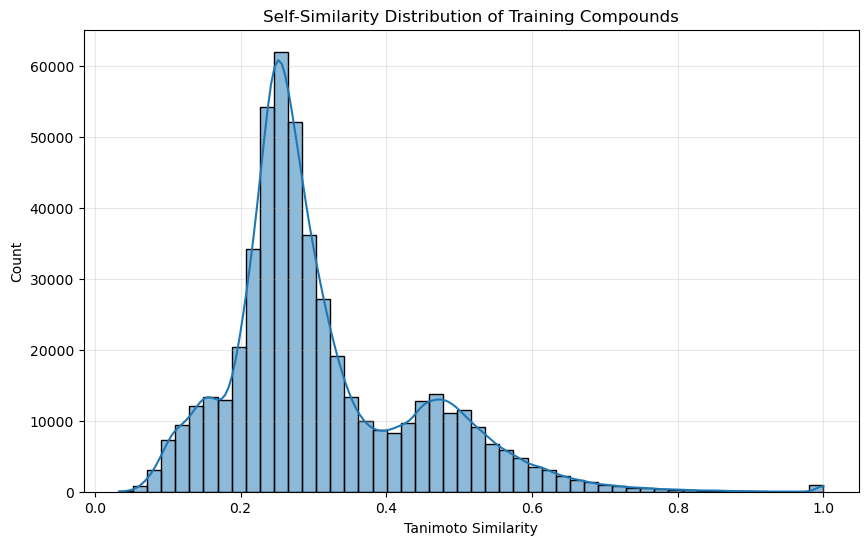

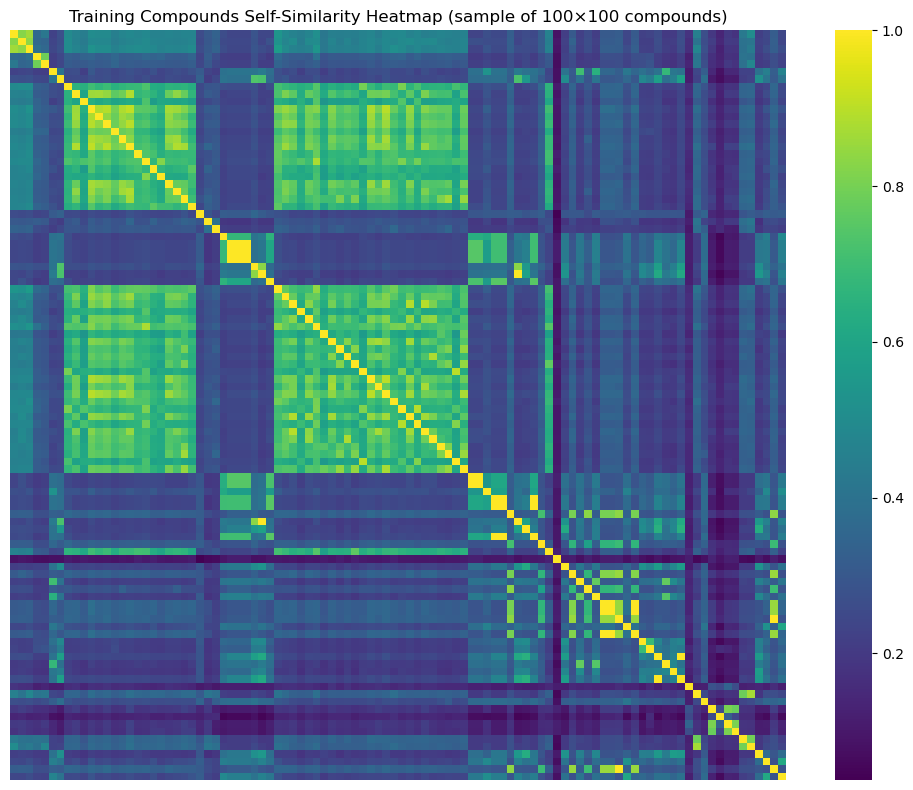


Test set self-similarity statistics:
  Mean: 0.3652
  Median: 0.2727
  Min: 0.0283
  Max: 1.0000


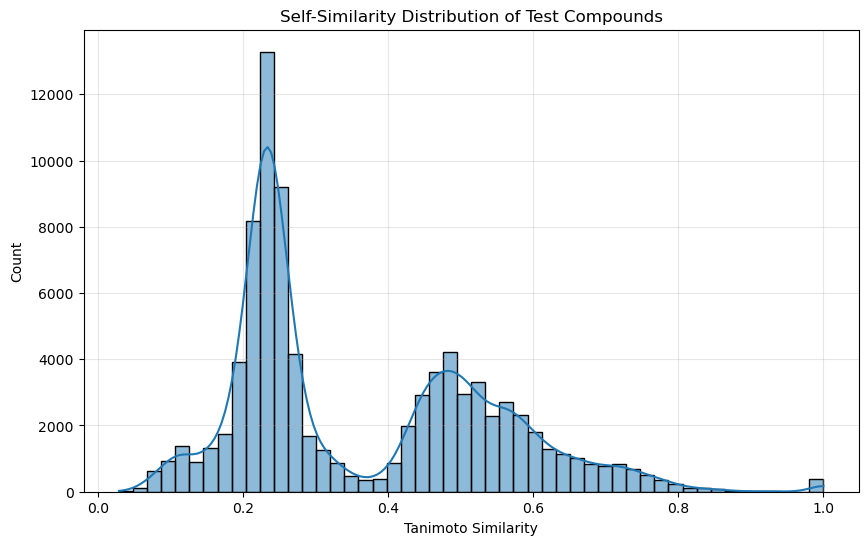

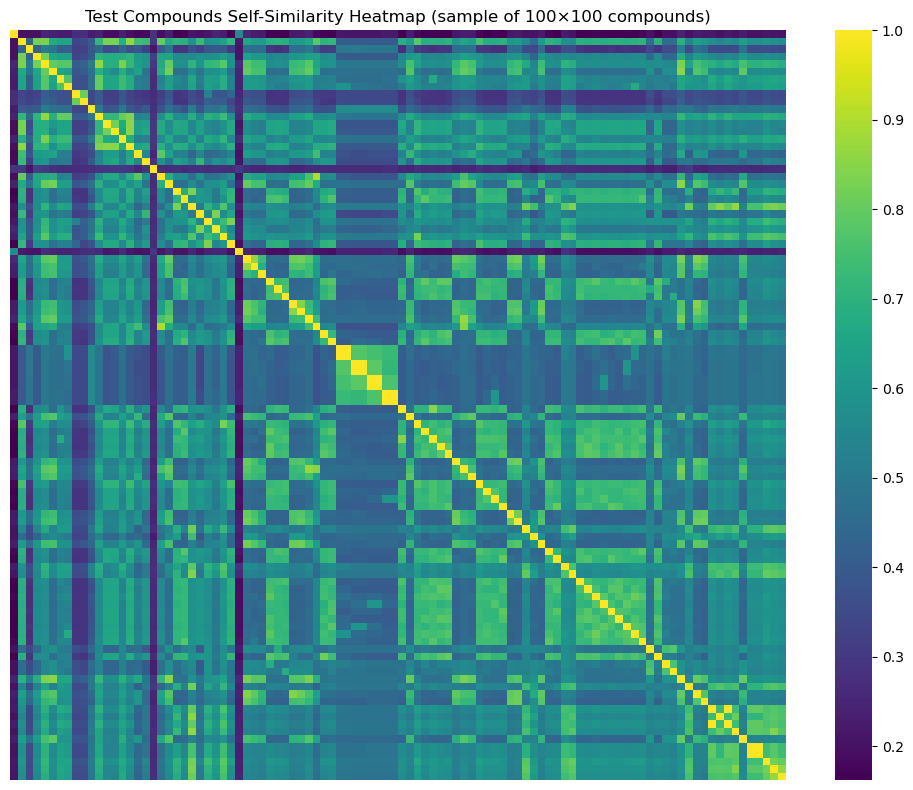


Training vs Test similarity statistics:
  Mean: 0.3162
  Median: 0.2674
  Min: 0.0286
  Max: 1.0000


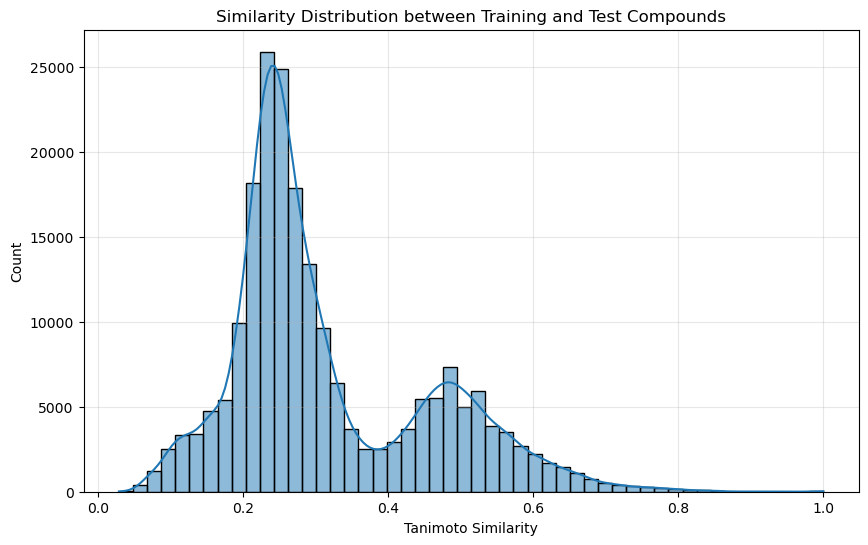

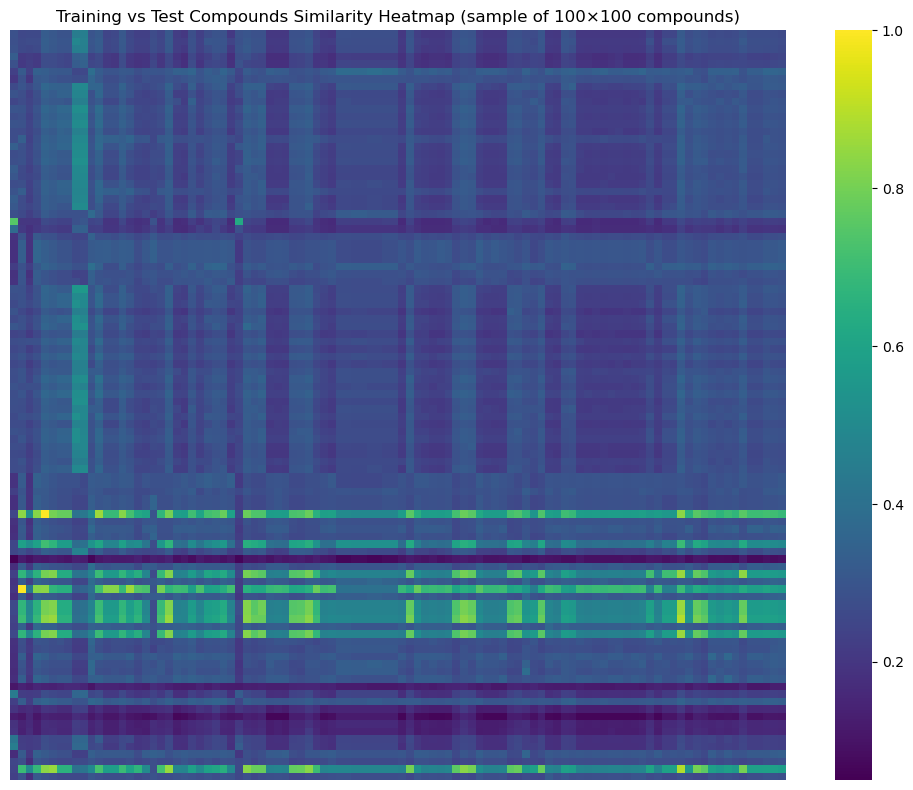


Analyzing test compounds with close analogs in training set...
Test compounds with at least one training analog at 0.5 similarity: 295/297 (99.33%)
Test compounds with at least one training analog at 0.7 similarity: 264/297 (88.89%)
Test compounds with at least one training analog at 0.9 similarity: 42/297 (14.14%)


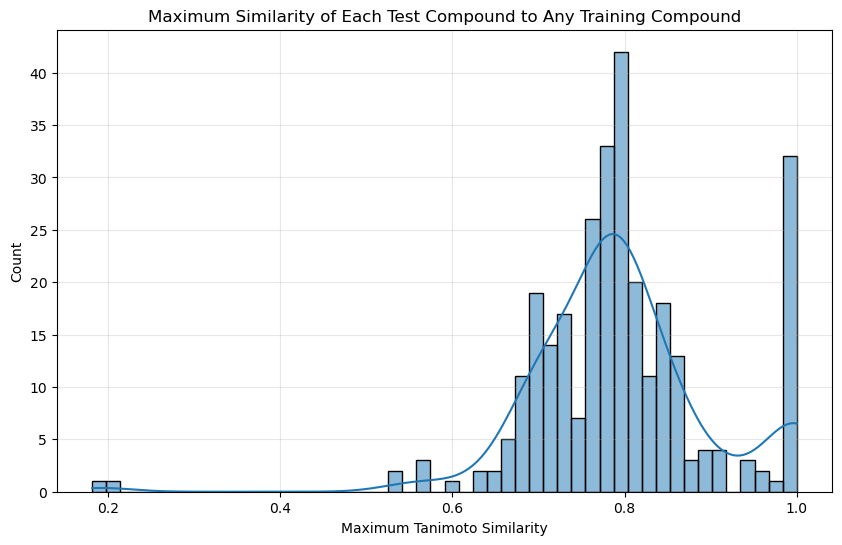


Analyzing correlation between SARS and MERS activities...


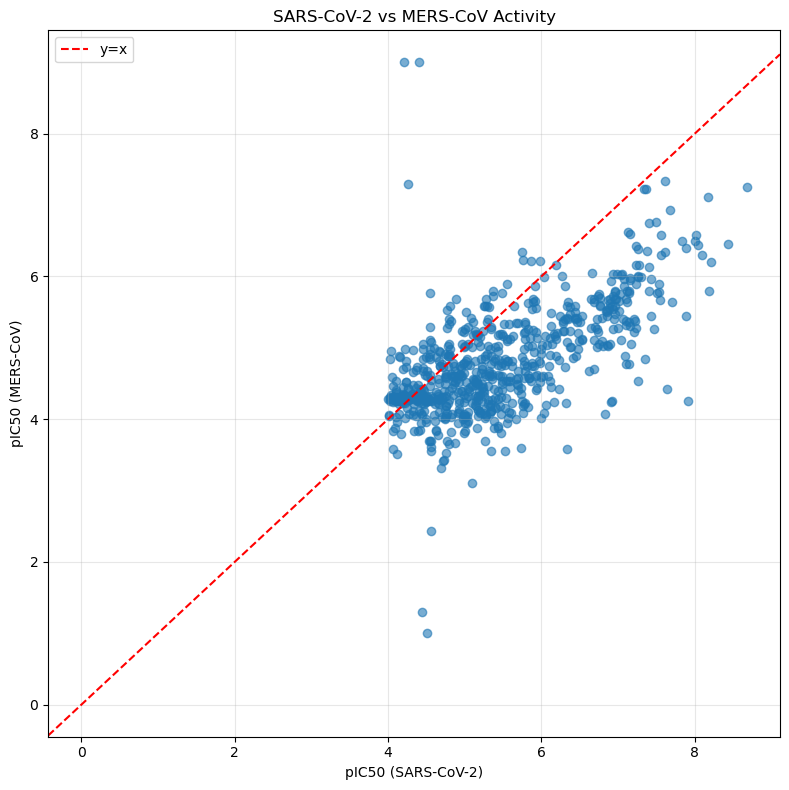

Correlation between SARS and MERS activities: 0.6300
Linear regression results:
  R²: 0.3969
  Slope: 0.4705
  Intercept: 2.2259
  Equation: MERS_pIC50 = 0.4705 × SARS_pIC50 + 2.2259

Similarity analysis complete!


In [5]:


# -------------------------------------------------
# Ligand Similarity Analysis for SARS and MERS
# -------------------------------------------------


# Function to calculate similarity matrix
def calculate_similarity_matrix(fps1, fps2=None):
    """
    Calculate Tanimoto similarity matrix between two sets of fingerprints.
    If fps2 is None, calculate self-similarity of fps1.
    """
    if fps2 is None:
        fps2 = fps1
    
    n1 = len(fps1)
    n2 = len(fps2)
    sim_matrix = np.zeros((n1, n2))
    
    for i in range(n1):
        for j in range(n2):
            sim_matrix[i, j] = DataStructs.TanimotoSimilarity(fps1[i], fps2[j])
    
    return sim_matrix

# Function to plot similarity distributions
def plot_similarity_distributions(sim_matrix, title, xlabel="Tanimoto Similarity", save_path=None):
    plt.figure(figsize=(10, 6))
    sns.histplot(sim_matrix.flatten(), bins=50, kde=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.grid(True, alpha=0.3)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Function to create a heatmap of similarities
def plot_similarity_heatmap(sim_matrix, title, save_path=None, max_compounds=100):
    """
    Create a heatmap of similarities between molecules
    Limit to max_compounds to keep visualization manageable
    """
    # Subsample if necessary
    if sim_matrix.shape[0] > max_compounds or sim_matrix.shape[1] > max_compounds:
        n_rows = min(sim_matrix.shape[0], max_compounds)
        n_cols = min(sim_matrix.shape[1], max_compounds)
        sampled_matrix = sim_matrix[:n_rows, :n_cols]
    else:
        sampled_matrix = sim_matrix
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(sampled_matrix, cmap="viridis", xticklabels=False, yticklabels=False)
    plt.title(f"{title} (sample of {sampled_matrix.shape[0]}×{sampled_matrix.shape[1]} compounds)")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Function to compute Morgan fingerprints for SMILES
def compute_fingerprints(smiles_list):
    """Compute Morgan fingerprints (ECFP4) for a list of SMILES"""
    fingerprints = []
    valid_smiles = []
    
    for smi in tqdm(smiles_list, desc="Computing fingerprints"):
        try:
            mol = Chem.MolFromSmiles(smi)
            if mol:
                # Morgan fingerprints with radius 2 (ECFP4)
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
                fingerprints.append(fp)
                valid_smiles.append(smi)
        except Exception as e:
            print(f"Error processing {smi}: {e}")
    
    return fingerprints, valid_smiles

print("Analyzing ligand similarities between SARS and MERS datasets...")

# Extract SMILES strings
sars_smiles = mpro_df_comp['SMILES'].tolist()  # Training SARS compounds
mers_smiles = mpro_df_comp['SMILES'].tolist()  # Training MERS compounds (same as SARS in your case)
test_smiles = test.X  # Test compounds

print(f"Number of training compounds: {len(sars_smiles)}")
print(f"Number of test compounds: {len(test_smiles)}")

# Compute fingerprints
print("\nComputing fingerprints for training compounds...")
train_fps, train_valid_smiles = compute_fingerprints(sars_smiles)

print("\nComputing fingerprints for test compounds...")
test_fps, test_valid_smiles = compute_fingerprints(test_smiles)

# Calculate similarity matrices
print("\nCalculating similarity matrices...")

# Training set self-similarity
train_self_sim = calculate_similarity_matrix(train_fps)

# Test set self-similarity
test_self_sim = calculate_similarity_matrix(test_fps)

# Training vs Test similarity
train_test_sim = calculate_similarity_matrix(train_fps, test_fps)

# Analyze and visualize similarity distributions
print("\nAnalyzing similarity distributions...")

# 1. Training set self-similarity
print(f"Training set self-similarity statistics:")
train_sim_flat = train_self_sim.flatten()
print(f"  Mean: {np.mean(train_sim_flat):.4f}")
print(f"  Median: {np.median(train_sim_flat):.4f}")
print(f"  Min: {np.min(train_sim_flat):.4f}")
print(f"  Max: {np.max(train_sim_flat):.4f}")

plot_similarity_distributions(
    train_self_sim, 
    "Self-Similarity Distribution of Training Compounds",
    save_path="train_self_similarity_dist.png"
)

plot_similarity_heatmap(
    train_self_sim,
    "Training Compounds Self-Similarity Heatmap",
    save_path="train_self_similarity_heatmap.png"
)

# 2. Test set self-similarity
print(f"\nTest set self-similarity statistics:")
test_sim_flat = test_self_sim.flatten()
print(f"  Mean: {np.mean(test_sim_flat):.4f}")
print(f"  Median: {np.median(test_sim_flat):.4f}")
print(f"  Min: {np.min(test_sim_flat):.4f}")
print(f"  Max: {np.max(test_sim_flat):.4f}")

plot_similarity_distributions(
    test_self_sim, 
    "Self-Similarity Distribution of Test Compounds",
    save_path="test_self_similarity_dist.png"
)

plot_similarity_heatmap(
    test_self_sim,
    "Test Compounds Self-Similarity Heatmap",
    save_path="test_self_similarity_heatmap.png"
)

# 3. Training vs Test similarity
print(f"\nTraining vs Test similarity statistics:")
train_test_flat = train_test_sim.flatten()
print(f"  Mean: {np.mean(train_test_flat):.4f}")
print(f"  Median: {np.median(train_test_flat):.4f}")
print(f"  Min: {np.min(train_test_flat):.4f}")
print(f"  Max: {np.max(train_test_flat):.4f}")

plot_similarity_distributions(
    train_test_sim, 
    "Similarity Distribution between Training and Test Compounds",
    save_path="train_test_similarity_dist.png"
)

plot_similarity_heatmap(
    train_test_sim,
    "Training vs Test Compounds Similarity Heatmap",
    save_path="train_test_similarity_heatmap.png"
)

# Analyze how many test compounds have close analogs in the training set
print("\nAnalyzing test compounds with close analogs in training set...")

similarity_thresholds = [0.5, 0.7, 0.9]
for threshold in similarity_thresholds:
    # For each test compound, find the maximum similarity to any training compound
    max_similarities = np.max(train_test_sim, axis=0)
    n_similar = np.sum(max_similarities >= threshold)
    percentage = (n_similar / len(max_similarities)) * 100
    
    print(f"Test compounds with at least one training analog at {threshold} similarity: "
          f"{n_similar}/{len(max_similarities)} ({percentage:.2f}%)")

# Visualize the maximum similarity for each test compound
plt.figure(figsize=(10, 6))
sns.histplot(np.max(train_test_sim, axis=0), bins=50, kde=True)
plt.title("Maximum Similarity of Each Test Compound to Any Training Compound")
plt.xlabel("Maximum Tanimoto Similarity")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.savefig("test_max_similarity_to_training.png", dpi=300, bbox_inches='tight')
plt.show()

# SARS vs MERS specific analysis
# Since in your case the compounds are the same for SARS and MERS,
# we're comparing the activity values instead

print("\nAnalyzing correlation between SARS and MERS activities...")

# Scatter plot of SARS vs MERS activities
plt.figure(figsize=(8, 8))
plt.scatter(Y_sars, Y_mers, alpha=0.6)
plt.title("SARS-CoV-2 vs MERS-CoV Activity")
plt.xlabel("pIC50 (SARS-CoV-2)")
plt.ylabel("pIC50 (MERS-CoV)")
plt.grid(True, alpha=0.3)
plt.axline([0, 0], [1, 1], color='red', linestyle='--', label="y=x")
plt.legend()
plt.tight_layout()
plt.savefig("sars_vs_mers_activity.png", dpi=300, bbox_inches='tight')
plt.show()

# Calculate correlation
correlation = np.corrcoef(Y_sars, Y_mers)[0, 1]
print(f"Correlation between SARS and MERS activities: {correlation:.4f}")

# Linear regression to quantify the relationship
from sklearn.linear_model import LinearRegression
X = Y_sars.reshape(-1, 1)
model = LinearRegression().fit(X, Y_mers)
r_squared = model.score(X, Y_mers)
slope = model.coef_[0]
intercept = model.intercept_

print(f"Linear regression results:")
print(f"  R²: {r_squared:.4f}")
print(f"  Slope: {slope:.4f}")
print(f"  Intercept: {intercept:.4f}")
print(f"  Equation: MERS_pIC50 = {slope:.4f} × SARS_pIC50 + {intercept:.4f}")
print("\nSimilarity analysis complete!")